<a href="https://colab.research.google.com/github/mingd00/Face-Recognition/blob/main/Notebooks/Xception%26Basic(with%20Fer2013).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 얼굴 감정 인식

### 0. 개요
- 영상을 업로드 하면 얼굴에서 감정을 인식하여 %로 반환
- Kaggle FER2013 emotion recognition 데이터 활용

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 라이브러리 불러오기

In [1]:
## 일반
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

## 이미지 처리
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

## CNN models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization, Input, GlobalAveragePooling2D, Add
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

## SVM models
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

## Same trained models
import h5py
from tensorflow.keras.models import model_from_json
import pickle

In [42]:
print(tf.__version__)

2.17.1


In [45]:
!python --version

Python 3.11.11


### 2. 데이터 불러오기

In [2]:
path = '/content/'

In [12]:
pd.options.mode.chained_assignment = None # df를 여러 번 인덱싱 or 슬라이싱 할 때 발생하는 오류 비활성호
dataset = pd.read_csv(path + 'fer2013.csv')

train = dataset[dataset["Usage"] == "Training"]
test = dataset[dataset["Usage"] == "PublicTest"]

# 공백으로 구분된 문자열을 Numpy 배열로 변환
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

- 데이터 탐색

In [13]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


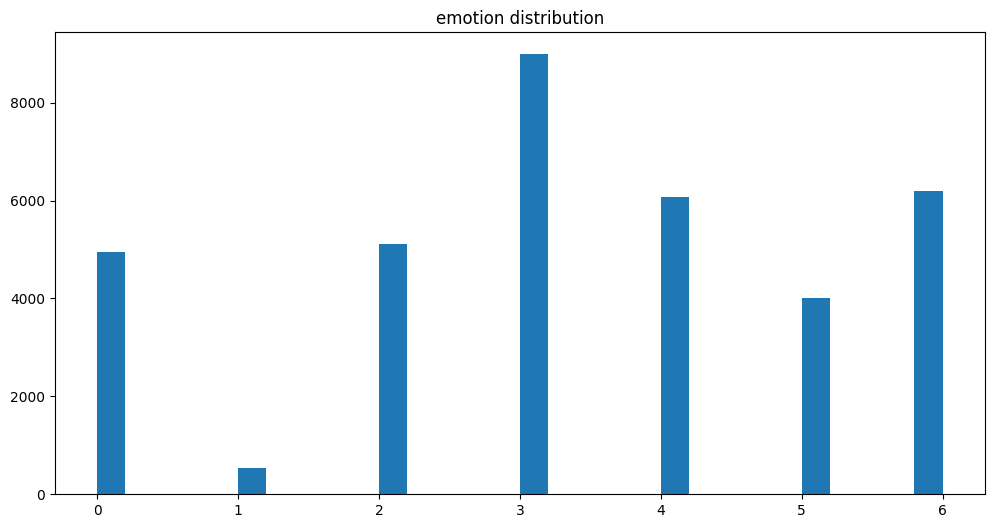

In [14]:
plt.figure(figsize=(12, 6))
plt.hist(dataset["emotion"], bins=30)
plt.title("emotion distribution")
plt.show()

In [15]:
train.shape, test.shape

((28709, 3), (3589, 3))

### 3. 데이터셋 생성

In [16]:
shape_x, shape_y = 48, 48

In [17]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

# 데이터를 세로로 쌓아서 2D 배열 생성
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

# 데이터 차원 변경(X는 4D, y는 2D)
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28709, 48, 48, 1), (28709, 1), (3589, 48, 48, 1), (3589, 1))

In [18]:
# float 타입으로 변환
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# 스케일링
train_data /= 255
test_data /= 255

# 원-핫 인코딩
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

### 4. 클래스 정의

In [19]:
classes = np.unique(y_train)
nClasses = len(classes)
nClasses, classes

(7, array([0, 1, 2, 3, 4, 5, 6]))

In [20]:
# 입력 이미지의 차원 추출
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

In [21]:
# 라벨 정의
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

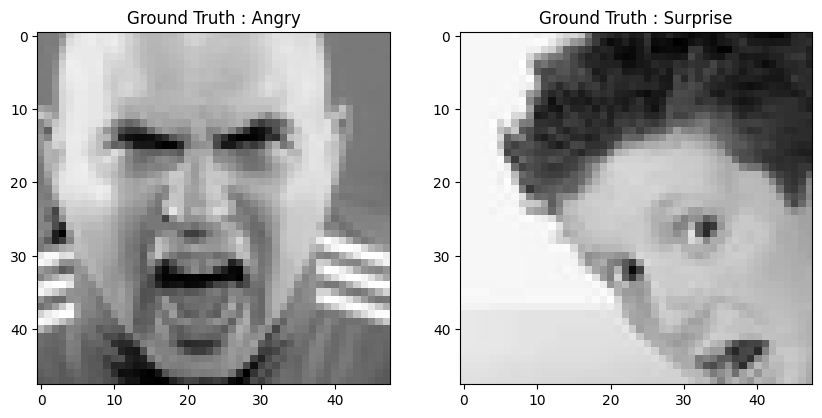

In [22]:
plt.figure(figsize=[10,5])

# 훈련 데이터
plt.subplot(121)
plt.imshow(np.squeeze(X_train[22,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0].item()))))

# 테스트 데이터
plt.subplot(122)
plt.imshow(np.squeeze(X_test[20,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500].item()))))

plt.show()

### 5. 얼굴 탐지

In [23]:
def detect_face(frame):
    # 얼굴 탐지를 위해 OpenCV에서 제공하는 사전 학습된 Haar Cascade 분류기 모델 파일 경로 설정
    cascPath = path + 'haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)  # 분류기 초기화

    # 입력된 프레임을 BGR 색상에서 회색조(Grayscale)로 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 다중 스케일의 얼굴을 탐지하기 위해 CascadeClassifier의 detectMultiScale 함수 사용
    detected_faces = faceCascade.detectMultiScale(
        gray,               # 회색조 이미지에서 얼굴 탐지
        scaleFactor=1.1,    # 이미지 크기를 10%씩 줄여가며 검색
        minNeighbors=6,     # 탐지된 영역 주변의 이웃 수를 설정 (값이 높을수록 더 정확한 탐지)
        minSize=(shape_x, shape_y),  # 탐지할 최소 얼굴 크기
        flags=cv2.CASCADE_SCALE_IMAGE  # 기본 이미지 크기에서만 검색
    )

    # 얼굴의 좌표를 저장할 리스트
    coord = []

    # 탐지된 얼굴 좌표를 반복하여 처리
    for x, y, w, h in detected_faces:
        if w > 100:  # 너비가 100 픽셀보다 큰 경우만 처리 (작은 얼굴은 무시)
            sub_img = frame[y:y+h, x:x+w]  # 얼굴 영역을 잘라내어 하위 이미지로 저장
            # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1)  # (옵션) 얼굴에 사각형 표시
            coord.append([x, y, w, h])  # 얼굴의 좌표(x, y, 너비, 높이)를 coord 리스트에 추가

    # 회색조 이미지, 탐지된 얼굴 영역, 좌표를 반환
    return gray, detected_faces, coord

In [24]:
# 얼굴 특징 추출
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    # 입력된 데이터에서 회색조 이미지와 탐지된 얼굴 좌표 가져오기
    gray = faces[0]          # 회색조 이미지
    detected_face = faces[1] # 탐지된 얼굴 좌표

    # 결과로 반환할 얼굴 특징 리스트
    new_face = []

    # 탐지된 얼굴을 반복 처리
    for det in detected_face:
        x, y, w, h = det

        horizontal_offset = int(np.floor(offset_coefficients[0] * w))
        vertical_offset = int(np.floor(offset_coefficients[1] * h))

        # 추출할 얼굴 영역 설정
        extracted_face = gray[
            y + vertical_offset : y + h,
            x + horizontal_offset : x - horizontal_offset + w
        ]

        # 추출된 얼굴 이미지를 줌 조정 (설정된 크기로 스케일 변경)
        new_extracted_face = zoom(
            extracted_face,
            (shape_x / extracted_face.shape[0], shape_y / extracted_face.shape[1])  # 목표 크기로 조정
        )

        # 데이터를 float32 형식으로 변환
        new_extracted_face = new_extracted_face.astype(np.float32)

        # 이미지를 정규화 (최대값으로 나누어 0~1 사이 값으로 변환)
        new_extracted_face /= float(new_extracted_face.max())

        # 정규화된 얼굴 이미지를 결과 리스트에 추가
        new_face.append(new_extracted_face)

    # 정규화된 모든 얼굴 이미지를 반환
    return new_face

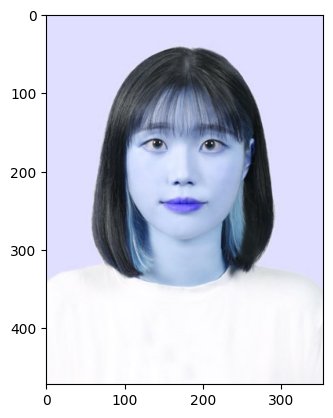

In [26]:
img = path + 'img.jpg'
img_face = cv2.imread(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_face)

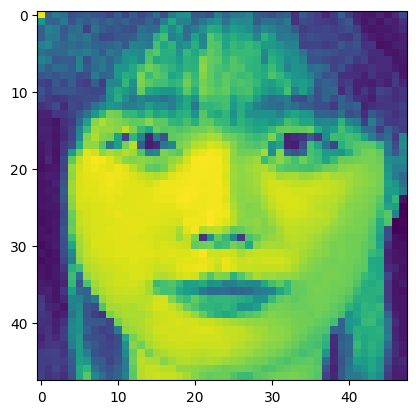

In [27]:
face = extract_face_features(detect_face(img_face))[0]
plt.imshow(face)

### 6. 딥러닝 모델 설계

- 기본 모델

In [ ]:
def createModel():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(nClasses, activation='softmax'))

    return model

- Overfitting 방지

In [ ]:
def createModel2():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dense(nClasses, activation='softmax'))

    return model

- Layers 추가

In [ ]:
def createModel3():
    model = Sequential()

    model.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))

    model.add(Flatten())

    model.add(Dense(1000, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(nClasses, activation='softmax'))

    return model

- 모델 선택

In [ ]:
model = createModel3()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 20)          │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 48, 48, 30)          │           5,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 30)          │             120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 24, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 40)          │          10,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 50)          │          18,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 50)          │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 60)          │          27,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 70)          │          37,870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 70)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 70)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 6, 6, 80)            │          50,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 6, 6, 90)            │          64,890 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3240)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │       3,241,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         512,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,972,243 (15.15 MB)

 Trainable params: 3,972,083 (15.15 MB)

 Non-trainable params: 160 (640.00 B)

### 7. 모델 학습

In [ ]:
# 데이터 증강
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [ ]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 50

history = model.fit(datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
                    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
                    epochs = epochs,
                    validation_data=(test_data, test_labels_one_hot)
                    )

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 259ms/step - accuracy: 0.2469 - loss: 1.9098 - val_accuracy: 0.2494 - val_loss: 1.8275
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2494 - val_loss: 1.8275
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.3269 - loss: 1.6807 - val_accuracy: 0.2940 - val_loss: 2.0237
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2940 - val_loss: 2.0237
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.3985 - loss: 1.5359 - val_accuracy: 0.2371 - val_loss: 1.8232
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2371 - val_loss: 1.8232
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.4440 - loss: 1.4350 - val_accuracy: 0.3282 - val_loss: 1.7383
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3282 - val_loss: 1.7383
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.4725 

### 8. 모델 평가

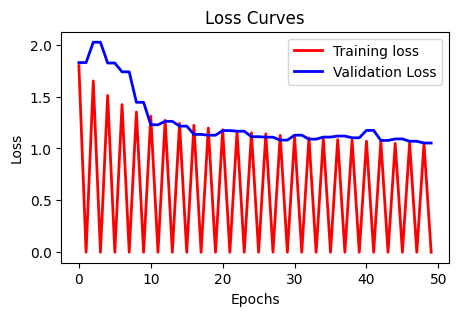

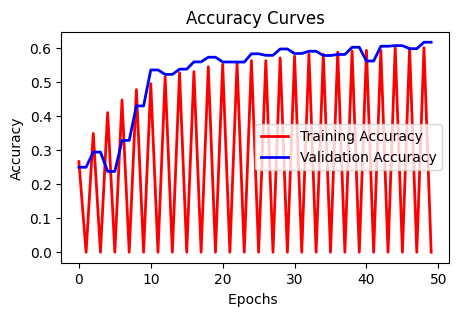

In [ ]:
# 손실 함수
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

# 정확도
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs ')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()

### 9. 모델 저장 및 호출

In [ ]:
# 모델 저장
json_string = model.to_json()
model.save_weights(path + 'model.weights.h5')
open(path + 'model.json', 'w').write(json_string)

14849

In [ ]:
# 저장한 모델 불러오기
with open(path + 'model.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights(path + 'model.weights.h5')
print("Loaded Complete")

Loaded Complete


### 10. 예측하기

- 사진

In [ ]:
img = path + 'img.jpg'
img_face = cv2.imread(img)

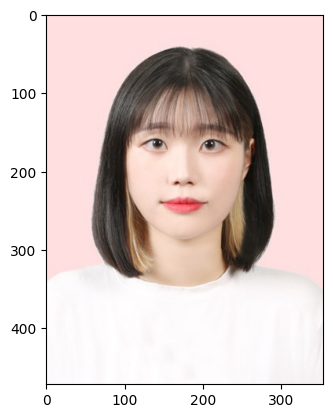

In [ ]:
plt.imshow(cv2.cvtColor(img_face, cv2.COLOR_BGR2RGB))

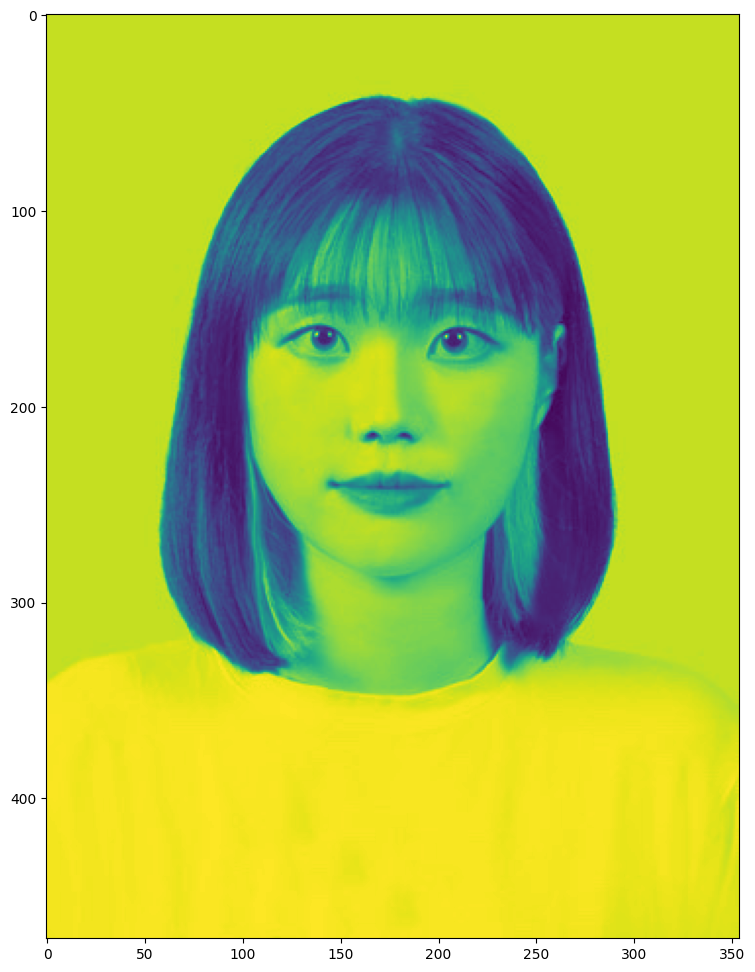

In [ ]:
# 객체 탐지
plt.figure(figsize=(12,12))
plt.imshow(detect_face(img_face)[0])
plt.show()

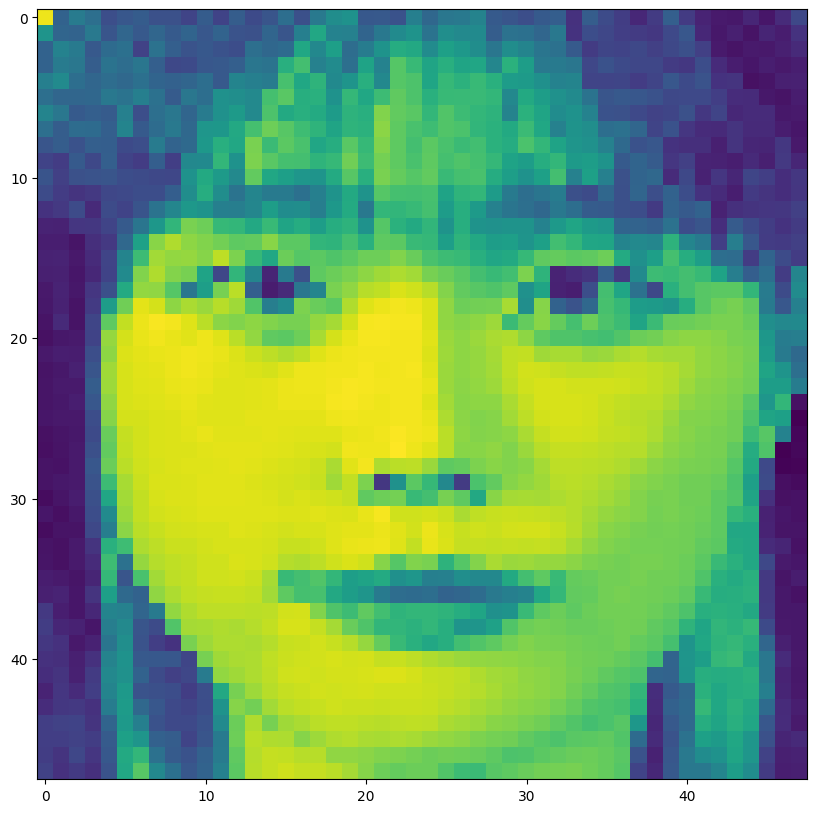

In [ ]:
# 특징 추출
for face in extract_face_features(detect_face(img_face)) :
    plt.figure(figsize=(10,10))
    plt.imshow(face)
    plt.show()

In [ ]:
# 클래스 예측
for face in extract_face_features(detect_face(img_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = model.predict(to_predict)
    result_num = np.argmax(res)
    print(result_num)
    print(get_label(result_num))
    for i, prob in enumerate(res[0]):
      print(f"Class {i} ({get_label(i)}): {prob * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
6
Neutral
Class 0 (Angry): 0.77%
Class 1 (Disgust): 0.00%
Class 2 (Fear): 1.78%
Class 3 (Happy): 1.86%
Class 4 (Sad): 3.89%
Class 5 (Surprise): 0.37%
Class 6 (Neutral): 91.33%


In [46]:
import cv2
import time
from google.colab.patches import cv2_imshow  # Colab에서 이미지를 표시하기 위해 임포트

# 영상 파일 경로
video_path = 'video.mp4'  # 영상 파일 경로 지정

# 영상 파일 열기
video_capture = cv2.VideoCapture(video_path)

# 영상의 FPS 확인
fps = video_capture.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
frame_interval = int(fps)  # 초당 프레임 수로 1초마다 프레임 추출

# 현재 시간
frame_count = 0  # 프레임을 카운트하는 변수

while True:
    # 영상에서 프레임 읽기
    ret, frame = video_capture.read()

    # 프레임이 제대로 읽어졌는지 확인
    if not ret:
        print("영상에서 프레임을 읽을 수 없습니다.")
        break

    # 1초마다 프레임을 추출하여 표시
    if frame_count % frame_interval == 0:  # FPS 기준으로 1초마다
        # 프레임을 화면에 표시
        for face in extract_face_features(detect_face(frame)):
          to_predict = np.reshape(face.flatten(), (1,48,48,1))
          res = model.predict(to_predict)
          result_num = np.argmax(res)
          print(result_num)
          print(get_label(result_num))

        # 각 클래스에 대한 확률을 출력
        for i, prob in enumerate(res[0]):
            print(f"Class {i} ({get_label(i)}): {prob * 100:.2f}%")  # 확률을 백분율로 출력
        print(frame_count // frame_interval)

    # 프레임 카운트 증가
    frame_count += 1

# 모든 작업 완료 후 캡처 리소스 해제
video_capture.release()
cv2.destroyAllWindows()

영상에서 프레임을 읽을 수 없습니다.


## XCeption 모델 사용
- Inception 아키텍처의 변형으로 대규모 데이터셋에서 뛰어난 성능을 보임
- Depthwise Separable Convolution
  - Depthwise Convolution: 각 입력 채널에 별도의 필터 적용
  - Pointwise Convolution: 각 깊이별 필터 출력을 1X1 크기의 필터로 결합
  

In [28]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = Add()([x, residual])
        previous_block_activation = x

    return x

In [29]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [30]:
def exit_flow(x, num_classes=7) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return x

In [31]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

xception = Model(inputs, outputs)
xception.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 24, 24, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 24, 24, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 24, 24, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 24, 24, 64)     │         18,496 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 24, 24, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 24, 24, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 24, 24, 64)     │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 24, 24, 128)    │          8,896 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 24, 24, 128)    │            512 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 24, 24, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 24, 24, 128)    │         17,664 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 24, 24, 128)    │            512 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 12, 12, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 12, 12, 128)    │          8,320 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 12, 12, 128)    │              0 │ max_pooling2d[0][0],   │
│                      

 Total params: 17,642,719 (67.30 MB)

 Trainable params: 17,596,127 (67.12 MB)

 Non-trainable params: 46,592 (182.00 KB)

In [33]:
# 모델 컴파일 및 학습
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 15

# 데이터 증강
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit(datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
                        epochs = epochs,
                        validation_data=(test_data, test_labels_one_hot)
                      )

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 106s 245ms/step - accuracy: 0.3049 - loss: 1.7503 - val_accuracy: 0.1819 - val_loss: 1.9012
Epoch 2/15


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1819 - val_loss: 1.9012
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 130ms/step - accuracy: 0.4424 - loss: 1.4508 - val_accuracy: 0.1819 - val_loss: 2.2665
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1819 - val_loss: 2.2665
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.5002 - loss: 1.3201 - val_accuracy: 0.3020 - val_loss: 2.5669
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3020 - val_loss: 2.5669
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.5271 - loss: 1.2542 - val_accuracy: 0.2647 - val_loss: 2.4296
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2647 - val_loss: 2.4296
Epoch 9/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.5452 

In [ ]:
# 모델 저장 및 호출
json_string = xception.to_json()
xception.save_weights(path + 'xception.weights.h5')
open(path + 'xception.json', 'w').write(json_string)

# 저장한 모델 불러오기
with open(path + 'xception.json','r') as f:
    json = f.read()
    xception = model_from_json(json)

    xception.load_weights(path + 'xception.weights.h5')
    print("Loaded Complete")

Loaded Complete


In [36]:
# 케라스로 저장 후 불러오기
from tensorflow.keras.models import load_model

xception.save("face_model.keras")
loaded_model = load_model("face_model.keras")

In [41]:
xception.save('/content/drive/MyDrive/face_model.keras')

In [37]:
# 사진 데이터 예측
img = path + 'img.jpg'
img_face = cv2.imread(img)

for face in extract_face_features(detect_face(img_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = xception.predict(to_predict)
    result_num = np.argmax(res)
    print(result_num)
    print(get_label(result_num))
    for i, prob in enumerate(res[0]):
      print(f"Class {i} ({get_label(i)}): {prob * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
6
Neutral
Class 0 (Angry): 44.17%
Class 1 (Disgust): 0.08%
Class 2 (Fear): 0.75%
Class 3 (Happy): 0.02%
Class 4 (Sad): 6.44%
Class 5 (Surprise): 0.50%
Class 6 (Neutral): 48.05%


In [ ]:
# 영상 데이터 예측
import cv2
import time
from google.colab.patches import cv2_imshow  # Colab에서 이미지를 표시하기 위해 임포트

# 영상 파일 경로
video_path = 'video.mp4'  # 영상 파일 경로 지정

# 영상 파일 열기
video_capture = cv2.VideoCapture(video_path)

# 영상의 FPS 확인
fps = video_capture.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
frame_interval = int(fps)  # 초당 프레임 수로 1초마다 프레임 추출

# 현재 시간
frame_count = 0  # 프레임을 카운트하는 변수

while True:
    # 영상에서 프레임 읽기
    ret, frame = video_capture.read()

    # 프레임이 제대로 읽어졌는지 확인
    if not ret:
        print("영상에서 프레임을 읽을 수 없습니다.")
        break

    # 1초마다 프레임을 추출하여 표시
    if frame_count % frame_interval == 0:  # FPS 기준으로 1초마다
        # 프레임을 화면에 표시
        for face in extract_face_features(detect_face(frame)):
          to_predict = np.reshape(face.flatten(), (1,48,48,1))
          res = xception.predict(to_predict)
          result_num = np.argmax(res)
          print(result_num)
          print(get_label(result_num))

        # 각 클래스에 대한 확률을 출력
        for i, prob in enumerate(res[0]):
            print(f"Class {i} ({get_label(i)}): {prob * 100:.2f}%")  # 확률을 백분율로 출력
        print(frame_count // frame_interval)

    # 프레임 카운트 증가
    frame_count += 1

# 모든 작업 완료 후 캡처 리소스 해제
video_capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3
Happy
Class 0 (Angry): 1.03%
Class 1 (Disgust): 0.05%
Class 2 (Fear): 0.28%
Class 3 (Happy): 90.14%
Class 4 (Sad): 2.43%
Class 5 (Surprise): 0.16%
Class 6 (Neutral): 5.92%
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6
Neutral
Class 0 (Angry): 0.29%
Class 1 (Disgust): 0.00%
Class 2 (Fear): 0.20%
Class 3 (Happy): 31.86%
Class 4 (Sad): 1.40%
Class 5 (Surprise): 0.23%
Class 6 (Neutral): 66.03%
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6
Neutral
Class 0 (Angry): 0.61%
Class 1 (Disgust): 0.00%
Class 2 (Fear): 0.59%
Class 3 (Happy): 19.30%
Class 4 (Sad): 4.34%
Class 5 (Surprise): 0.72%
Class 6 (Neutral): 74.44%
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6
Neutral
Class 0 (Angry): 14.14%
Class 1 (Disgust): 12.84%
Class 2 (Fear): 1.71%
Class 3 (Happy): 4.08%
Class 4 (Sad): 28.81%
Class 5 (Surprise): 0.61%
Class 6 (Neutral): 37.82%
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6
Neutral
Class 0 (Angry): 2.86%
Class 1 (Disgust): 0.17%
Class 2 (Fear): 0.75%
Class 3 (Happy)